# Bagging and Random Forest Models

Using **ensemble methods** can greatly improve the results achieved with weak machine learning algorithms, also called **weak learners**. Ensemble methods achieve better performance by aggregating the results of many statistically independent models. This process averages out the errors and produces a final better prediction. 

In this lab you will work with a widely used ensemble method known as **bootstrap aggregating** or simply **bagging**. Bagging follows a simple procedure:
1. N learners (machine learning models) are defined. 
2. N subsamples of the training data are created by **Bernoulli sampling with replacement**.
3. The N learners are trained on the subsamples of the training data.
4. The ensemble is scored by averaging, or taking a majority vote, of the predictions from the N learners.

**Classification and regression tree models** are most typically used with bagging methods. The most common such algorithm is know as the **random forest**. The random forest method is highly scalable and generally produces good results, even for complex problems. 

Classification and regression trees tend to be robust to noise or outliers in the training data. This is true for the random forest algorithm as well. 

## Example: Iris dataset

As a first example you will use random forest to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from statsmodels.api import datasets
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as nr

%matplotlib inline

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


To get a feel for these data, you will now load and plot them. The code in the cell below does the following:

1. Loads the iris data as a Pandas data frame. 
2. Adds column names to the data frame.
3. Displays all 4 possible scatter plot views of the data. 

Execute this code and examine the results. 

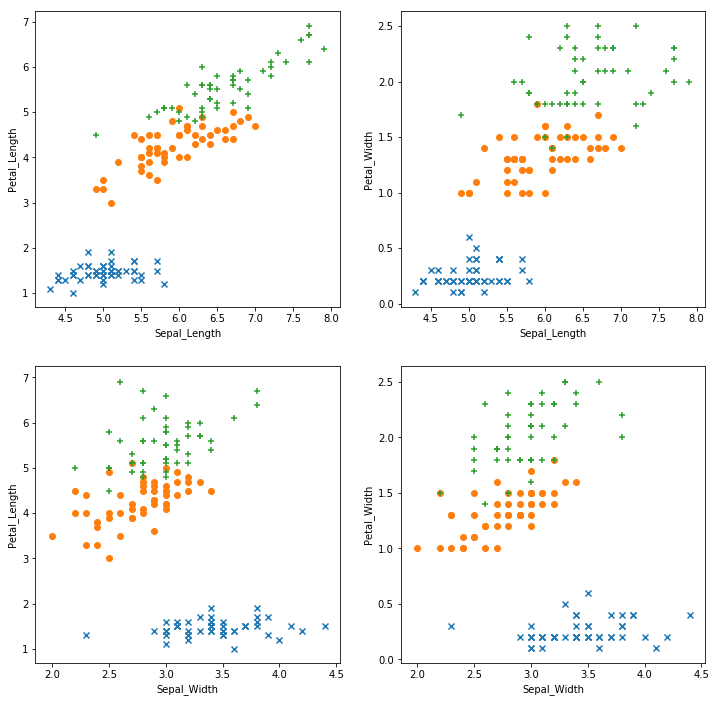

In [2]:
def plot_iris(iris):
    '''Function to plot iris data by type'''
    setosa = iris[iris['Species'] == 'setosa']
    versicolor = iris[iris['Species'] == 'versicolor']
    virginica = iris[iris['Species'] == 'virginica']
    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    x_ax = ['Sepal_Length', 'Sepal_Width']
    y_ax = ['Petal_Length', 'Petal_Width']
    for i in range(2):
        for j in range(2):
            ax[i,j].scatter(setosa[x_ax[i]], setosa[y_ax[j]], marker = 'x')
            ax[i,j].scatter(versicolor[x_ax[i]], versicolor[y_ax[j]], marker = 'o')
            ax[i,j].scatter(virginica[x_ax[i]], virginica[y_ax[j]], marker = '+')
            ax[i,j].set_xlabel(x_ax[i])
            ax[i,j].set_ylabel(y_ax[j])
            
## Import the dataset  
iris = datasets.get_rdataset("iris")
iris.data.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']

## Plot views of the iris data            
plot_iris(iris.data)    

You can see that Setosa (in blue) is well separated from the other two categories. The Versicolor (in orange) and the Virginica (in green) show considerable overlap. The question is how well our classifier will separate these categories. 

Scikit Learn classifiers require numerically coded numpy arrays for the features and as a label. The code in the cell below does the following processing:
1. Creates a numpy array of the features.
2. Numerically codes the label using a dictionary lookup, and converts it to a numpy array. 

Execute this code.

In [3]:
Features = np.array(iris.data[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']])

levels = {'setosa':0, 'versicolor':1, 'virginica':2}
Labels =  np.array([levels[x] for x in iris.data['Species']])

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 100 of the 150 cases are being used as the test dataset. 

In [4]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 100)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

As is always the case with machine learning, numeric features  must be scaled. The code in the cell below performs the following processing:

1. A Zscore scale object is defined using the `StandarScaler` function from the Scikit Learn preprocessing package. 
2. The scaler is fit to the training features. Subsequently, this scaler is used to apply the same scaling to the test data and in production. 
3. The training features are scaled using the `transform` method. 

Execute this code.

In [5]:
scale = preprocessing.StandardScaler()
scale.fit(x_train)
x_train = scale.transform(x_train)

Now you will define and fit a random forest model. The code in the cell below defines random forest model with 5 trees using the `RandomForestClassifer` function from the Scikit Learn ensemble  package, and then fits the model. Execute this code.

In [6]:
nr.seed(1115)
rf_clf = RandomForestClassifier(n_estimators=5)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Notice that the many hyperparameters of the random forest model object are displayed. 

Next, the code in the cell below performs the following processing to score the test data subset:
1. The test features are scaled using the scaler computed for the training features. 
2. The `predict` method is used to compute the scores from the scaled features. 

Execute this code. 

In [7]:
x_test = scale.transform(x_test)
scores = rf_clf.predict(x_test)

It is time to evaluate the model results. Keep in mind that the problem has been made difficult deliberately, by having more test cases than training cases. 

The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from pervious labs to deal with a three category problem. Execute this code and examine the results.

In [8]:
def print_metrics_3(labels, scores):
   
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score Setosa   Score Versicolor    Score Virginica')
    print('True Setosa     %6d' % conf[0,0] + '            %5d' % conf[0,1] + '             %5d' % conf[0,2])
    print('True Versicolor  %6d' % conf[1,0] + '            %5d' % conf[1,1] + '             %5d' % conf[1,2])
    print('True Vriginica   %6d' % conf[2,0] + '            %5d' % conf[2,1] + '             %5d' % conf[2,2])
    ## Now compute and display the accuracy and metrics
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    print(' ')
    print('          Snetosa  Versicolor  Virginica')
    print('Num case   %0.2f' % metrics[3][0] + '     %0.2f' % metrics[3][1] + '      %0.2f' % metrics[3][2])
    print('Precision   %0.2f' % metrics[0][0] + '      %0.2f' % metrics[0][1] + '       %0.2f' % metrics[0][2])
    print('Recall      %0.2f' % metrics[1][0] + '      %0.2f' % metrics[1][1] + '       %0.2f' % metrics[1][2])
    print('F1          %0.2f' % metrics[2][0] + '      %0.2f' % metrics[2][1] + '       %0.2f' % metrics[2][2])
    
print_metrics_3(y_test, scores)    

                 Confusion matrix
                 Score Setosa   Score Versicolor    Score Virginica
True Setosa         35                0                 0
True Versicolor       0               29                 5
True Vriginica        0                0                31

Accuracy        0.95
 
          Snetosa  Versicolor  Virginica
Num case   35.00     34.00      31.00
Precision   1.00      1.00       0.86
Recall      1.00      0.85       1.00
F1          1.00      0.92       0.93


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified with only a few errors. 
2. The overall accuracy is 0.94. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 50 cases. 
3. The precision, recall and  F1 for each of the classes is quite good.
|
To get a better feel for what the classifier is doing, the code in the cell below displays a set of plots showing correctly (as '+') and incorrectly (as 'o') cases, with the species color-coded. Execute this code and examine the results. 

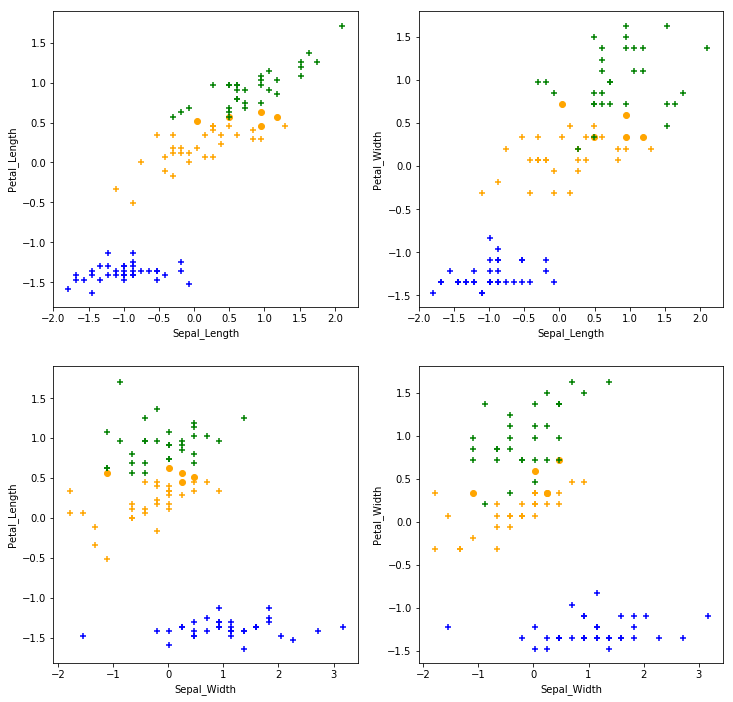

In [9]:
def plot_iris_score(iris, y_test, scores):
    '''Function to plot iris data by type'''
    ## Find correctly and incorrectly classified cases
    true = np.equal(scores, y_test).astype(int)
    
    ## Create data frame from the test data
    iris = pd.DataFrame(iris)
    levels = {0:'setosa', 1:'versicolor', 2:'virginica'}
    iris['Species'] = [levels[x] for x in y_test]
    iris.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']
    
    ## Set up for the plot
    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    markers = ['o', '+']
    x_ax = ['Sepal_Length', 'Sepal_Width']
    y_ax = ['Petal_Length', 'Petal_Width']
    
    for t in range(2): # loop over correct and incorect classifications
        setosa = iris[(iris['Species'] == 'setosa') & (true == t)]
        versicolor = iris[(iris['Species'] == 'versicolor') & (true == t)]
        virginica = iris[(iris['Species'] == 'virginica') & (true == t)]
        # loop over all the dimensions
        for i in range(2):
            for j in range(2):
                ax[i,j].scatter(setosa[x_ax[i]], setosa[y_ax[j]], marker = markers[t], color = 'blue')
                ax[i,j].scatter(versicolor[x_ax[i]], versicolor[y_ax[j]], marker = markers[t], color = 'orange')
                ax[i,j].scatter(virginica[x_ax[i]], virginica[y_ax[j]], marker = markers[t], color = 'green')
                ax[i,j].set_xlabel(x_ax[i])
                ax[i,j].set_ylabel(y_ax[j])

plot_iris_score(x_test, y_test, scores)

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

Is it possible that a random forest model with more trees would separate these cases better? The code in the cell below uses a model with 40 trees (estimators). This model is fit with the training data and displays the evaluation of the model. 

Execute this code and answer **Question 1** on the course page.

                 Confusion matrix
                 Score Setosa   Score Versicolor    Score Virginica
True Setosa         35                0                 0
True Versicolor       0               32                 2
True Vriginica        0                3                28

Accuracy        0.95
 
          Snetosa  Versicolor  Virginica
Num case   35.00     34.00      31.00
Precision   1.00      0.91       0.93
Recall      1.00      0.94       0.90
F1          1.00      0.93       0.92


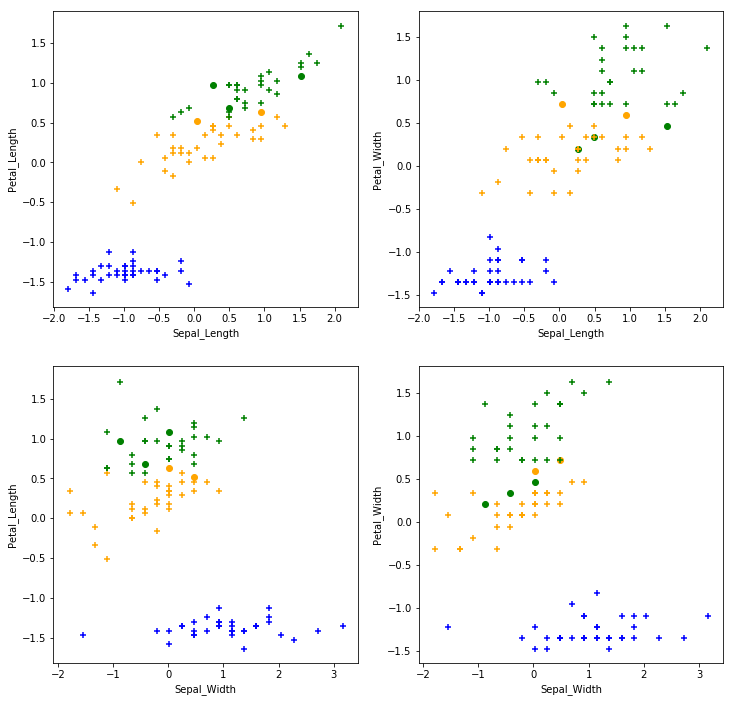

In [10]:
nr.seed(1115)
rf_clf = RandomForestClassifier(n_estimators=40)
rf_clf.fit(x_train, y_train)
scores = rf_clf.predict(x_test)
print_metrics_3(y_test, scores) 
plot_iris_score(x_test, y_test, scores)

These results are slightly better than for the model with 5 trees. However, this small difference in performance is unlikely to be significant. 

Like most tree-based models, random forest models have a nice property that **feature importance** is computed during model training. Feature importance can be used as a feature selection method. 

Execute the code in the cell below to display a plot of the feature importance.

Text(0,0.5,'Feature importance')

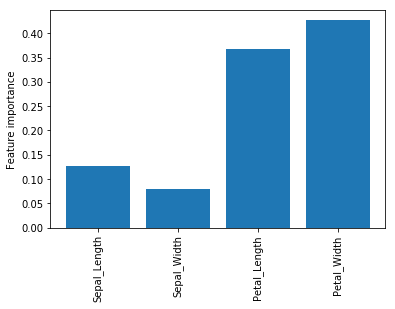

In [11]:
importance = rf_clf.feature_importances_
plt.bar(range(4), importance, tick_label = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
plt.xticks(rotation=90)
plt.ylabel('Feature importance')

Examine the plot displayed above. Notice that the Speal_Lenght and Sepal_Width have rather low importance. 

Should these features be dropped from the model? To find out, you will create a model with a reduced feature set and compare the results. As a first step, execute the code in the cell below to create training and test datasets using the reduced features.

In [12]:
## Create reduced feature set
Features = np.array(iris.data[['Petal_Length', 'Petal_Width']])

## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 100)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

Next, execute the code in the cell below to define the model, fit the model, score the model and print the results. 

Once you have executed the code, answer **Question 2** on the course page.

In [13]:
nr.seed(1115)
rf_clf = RandomForestClassifier(n_estimators=40)
rf_clf.fit(x_train, y_train)
scores = rf_clf.predict(x_test)
print_metrics_3(y_test, scores) 

                 Confusion matrix
                 Score Setosa   Score Versicolor    Score Virginica
True Setosa         35                0                 0
True Versicolor       0               30                 4
True Vriginica        0                2                29

Accuracy        0.94
 
          Snetosa  Versicolor  Virginica
Num case   35.00     34.00      31.00
Precision   1.00      0.94       0.88
Recall      1.00      0.88       0.94
F1          1.00      0.91       0.91


These results are nearly the same as those obtained with the full feature set. In all likelihood, there is no significant difference. Given that a simpler model is more likely to generalize, this model is preferred. 

## Another example

Now, you will try a more complex example using the credit scoring data. You will use the prepared data which had the following preprocessing:
1. Cleaning missing values.
2. Aggregating categories of certain categorical variables. 
3. Encoding categorical variables as binary dummy variables.
4. Standardizing numeric variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example. 

In [14]:
Features = np.array(pd.read_csv('Credit_Features.csv'))
Labels = np.array(pd.read_csv('Credit_Labels.csv'))
Labels = Labels.reshape(Labels.shape[0],)
print(Features.shape)
print(Labels.shape)

(1000, 35)
(1000,)


Nested cross validation is used to estimate the optimal hyperparameters and perform model selection for the random forest model. Since random forest models are efficient to train, 10 fold cross validation is used. Execute the code in the cell below to define inside and outside fold objects. 

In [15]:
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

The code in the cell below estimates the best hyperparameters using 10 fold cross validation. There are a few points to note here:
1. In this case, a grid of two hyperparameters is searched: 
  - max_features determines the maximum number of features used to determine the splits. Minimizing the number of features can prevent model over-fitted by induces bias. 
  - min_samples_leaf determines the minimum number of samples or leaves which must be on each terminal node of the tree. Maintaining the minimum number of samples per terminal node is a regularization method. Having too few samples on terminal leaves allows the model training to memorize the data, leading to high variance. Forcing too many samples on the terminal nodes leads to biased predictions. 
2. Since there is a class imbalance and a difference in the cost to the bank of misclassification of a bad credit risk customer, the "balanced" argument is used. The balanced argument ensures that the subsamples used to train each tree have balanced cases. 
3. The model is fit on each set of hyperparameters from the grid. 
4. The best estimated hyperparameters are printed. 

Notice that the model uses regularization rather than feature selection. The hyperparameter search is intended to optimize the level of regularization. 

Execute this code, examine the result, and answer **Question 3** on the course page.

In [16]:
## Define the dictionary for the grid search and the model object to search on
param_grid = {"max_features": [2, 3, 5, 10, 15], "min_samples_leaf":[3, 5, 10, 20]}
## Define the logistic regression model
nr.seed(3456)
rf_clf = RandomForestClassifier(n_estimators=40, class_weight = "balanced") # class_weight = {0:0.33, 1:0.67}) 

## Perform the grid search over the parameters
nr.seed(4455)
rf_clf = ms.GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = sklm.make_scorer(sklm.roc_auc_score),
                      return_train_score = True)
rf_clf.fit(Features, Labels)
print(rf_clf.best_estimator_.max_features)
print(rf_clf.best_estimator_.min_samples_leaf)

15
10


Now, you will run the code in the cell below to perform the outer cross validation of the model. 

In [17]:
nr.seed(498)
cv_estimate = ms.cross_val_score(rf_clf, Features, Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('fold ' + str(i+1) + '   %4.3f' % x)

Mean performance metric = 0.702
SDT of the metric       = 0.034
Outcomes by cv fold
fold 1   0.706
fold 2   0.692
fold 3   0.647
fold 4   0.646
fold 5   0.724
fold 6   0.722
fold 7   0.694
fold 8   0.755
fold 9   0.737
fold 10   0.692


Examine these results. Notice that the standard deviation of the mean of the AUC is more than an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

Now, you will build and test a model using the estimated optimal hyperparameters. As a first step, execute the code in the cell below to create training and testing dataset.

In [18]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

The code in the cell below defines a random forest model object using the estimated optimal model hyperparameters and then fits the model to the training data. Execute this code.

In [19]:
nr.seed(1115)
rf_mod = RandomForestClassifier(n_estimators=40, class_weight = "balanced", max_features = 10, min_samples_leaf = 10) 
rf_mod.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

As expected, the hyperparemeters of the random forest model object reflect those specified. 

The code in the cell below scores and prints evaluation metrics for the model, using the test data subset. 

Execute this code, examine the results, and answer **Question 4** on the course page. 

In [20]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('True positive    %6d' % conf[0,0] + '          %5d' % conf[0,1])
    print('True negative    %6d' % conf[1,0] + '          %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, scores))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('             Positive   Negative')
    print('Num case    %0.2f' % metrics[3][0] + '       %0.2f' % metrics[3][1])
    print('Precision   %0.2f' % metrics[0][0] + '          %0.2f' % metrics[0][1])
    print('Recall      %0.2f' % metrics[1][0] + '          %0.2f' % metrics[1][1])
    print('F1          %0.2f' % metrics[2][0] + '          %0.2f' % metrics[2][1])

scores = rf_mod.predict(x_test)
print_metrics(y_test, scores)     

                 Confusion matrix
                 Score positive    Score negative
True positive       156             56
True negative        23             65

Accuracy        0.74
AUC             0.74
Macro precision 0.70
Macro recall    0.74
 
             Positive   Negative
Num case    212.00       88.00
Precision   0.87          0.54
Recall      0.74          0.74
F1          0.80          0.62


Overall, these performance metrics look quite good. A large majority of negative (bad credit) cases are identified at the expense of significant false positives. The reported AUC is within a standard deviation of the figure obtained with cross validation indicating that the model is generalizing well. 

## Summary

In this lab you have accomplished the following:
1. Used a random forest model to classify the cases of the iris data. A model with more trees had marginally lower error rates, but likely not significantly different.
2. Applied feature importance was used for feature selection with the iris data. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features.  
2. Used 10 fold to find estimated optimal hyperparameters for a random forest model to classify credit risk cases. The model appears to generalize well.  